In [1]:
import cartopy.crs as crs
import cartopy.feature as cfeature
from scipy import optimize
from scipy import stats
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.patches import Ellipse
import matplotlib.ticker as mtick
import shapely
import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import kaleido 
import contextily as cx
if not os.path.exists("/home/nen/Python/images"):
    os.mkdir("/home/nen/Python/images")
    


Calculates the economic value of the forecast 

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Reproject to Mercator (after dropping Antartica)
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
world = world.to_crs("EPSG:3857") # world.to_crs(epsg=3395) would also work
#check
#ax=world.plot(color='none', edgecolor='black',facecolor="none")
#ax.set_title("Mercator");
crs=world.crs

In [3]:
ignition = pd.read_csv('/perm/nen/pil/2020_GWLC_ignition.cvs')

#time in the right format 
ignition['time']= pd.to_datetime(ignition['time'], format='%Y-%m-%d')

ignition["latitude"]= ignition.latitude.round(0)
ignition["longitude"]= ignition.longitude.round(0)
ignition_l=ignition.loc[ignition['density'] >0]

#ignition=ignition.drop(columns=['STRF','frpfire','ign_burn','spread_zone','density','litota6'])
ignition_l=ignition_l.drop(columns=['STRF','frpfire','ign_burn','spread_zone','density','litota6'])
ignition_l

,latitude,longitude,time,ignition_no
24,-5.0,-45.0,2020-01-01,1.0
27,-15.0,132.0,2020-01-01,1.0
28,-17.0,140.0,2020-01-01,1.0
29,-17.0,139.0,2020-01-01,1.0
30,-17.0,139.0,2020-01-01,1.0
...,...,...,...,...
30066,-3.0,-42.0,2020-12-30,1.0
30067,-4.0,-42.0,2020-12-30,1.0
30069,-7.0,-48.0,2020-12-30,1.0
30070,-11.0,-55.0,2020-12-30,1.0


Deterministic forecast 

In [4]:
pil_det=xr.open_dataset("/perm/nen/pil/WEL2_LIHM_2020_det.nc" ,engine='netcdf4' )
pil_det['time']=pil_det.time.astype(int).astype(str)
pil_det=pil_det.coarsen(longitude=6).max().coarsen(latitude=6).max()
pil_det_df=pil_det.to_dataframe().reset_index().dropna()
pil_det_df['time']= pd.to_datetime(pil_det_df['time'], format='%Y%m%d')
pil_det_df.rename(columns={'WEL2_LIHM':'pred'},inplace=True)
pil_det_df['latitude']=pil_det_df.latitude.round(0)
pil_det_df['longitude']=pil_det_df.longitude.round(0)
#pil_det_df.loc[pil_det_df['pred']>0.5,'pred']= 1

In [5]:
#pil_det_df.loc[pil_det_df['pred']<=0.5,'pred']= 0
#pil_det_df.loc[pil_det_df['pred']==0.5,'pred']

In [6]:
new_df = pd.merge(pil_det_df, ignition_l,  how='outer', left_on=['time','latitude','longitude'],right_on=['time','latitude','longitude'])
new_df['ignition_no']=new_df['ignition_no'].fillna(0)
new_df['pred']=new_df['pred'].fillna(0)
#new_df.drop_duplicates(inplace=True)

In [7]:
tab = pd.crosstab(new_df['pred'], new_df['ignition_no'],colnames=['ignition'])
a=tab.loc[tab.index.get_level_values('pred') == 0, tab.columns.get_level_values('ignition') == 0].values
b=tab.loc[tab.index.get_level_values('pred') == 0, tab.columns.get_level_values('ignition') == 1].values
c=tab.loc[tab.index.get_level_values('pred') == 1, tab.columns.get_level_values('ignition') == 0].values
d=tab.loc[tab.index.get_level_values('pred') == 1, tab.columns.get_level_values('ignition') == 1].values
b+d

array([[2935]])

In [8]:
tot=a+b+c+d
a=a/tot
b=b/tot
c=c/tot
d=d/tot

o=(b+d)
F=c/(1-o)
H=d/o


In [9]:
nsim=int(1000)
th_ref=np.array([0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,0.95])
nth= len(th_ref)
C_L=np.zeros((nth+1,nsim),dtype=float)
V=np.zeros((nth+1,nsim),dtype=float)
for c_l  in range(1,nsim,1):
    alpha=c_l /nsim
    #print(alpha)
    num=(min(alpha,o))-(F*alpha*(1-o))+(H*o*(1-alpha))-o
    den=(min(alpha,o))-(o*alpha)
    #print(num/den)
    V[0,c_l]=max(num/den,0.0)
    C_L[0,c_l]=alpha

Probabilistic forecast 

In [10]:
pil_prob=xr.open_dataset("/perm/nen/pil/pil_2020.nc" ,engine='netcdf4' )
pil_prob['time']=pil_prob.time.astype(int).astype(str)
pil_prob=pil_prob.coarsen(longitude=6).mean().coarsen(latitude=6).mean()
pil_prob_df=pil_prob.to_dataframe().reset_index().dropna()
pil_prob_df['time']= pd.to_datetime(pil_prob_df['time'], format='%Y%m%d')
pil_prob_df.rename(columns={'WEL2_LIHM':'pred'},inplace=True)
pil_prob_df['latitude']=pil_prob_df.latitude.round(0)
pil_prob_df['longitude']=pil_prob_df.longitude.round(0)
pil_prob_df

,time,latitude,longitude,pred
15321,2020-01-01,-55.0,-71.0,0.000000
15322,2020-01-01,-55.0,-70.0,0.000000
15323,2020-01-01,-55.0,-69.0,0.004357
15324,2020-01-01,-55.0,-68.0,0.020153
15325,2020-01-01,-55.0,-67.0,0.000817
...,...,...,...,...
29020767,2020-12-31,46.0,151.0,0.000000
29024591,2020-12-31,55.0,-8.0,0.000000
29024592,2020-12-31,55.0,-7.0,0.000000
29024594,2020-12-31,55.0,-5.0,0.000000


In [11]:
#ranges of probabilities
for i in range(0, nth):
    prob=pil_prob_df.copy()
    prob.loc[prob['pred']<=th_ref[i],'pred']= 0
    prob.loc[prob['pred']>th_ref[i],'pred']= 1
    new_df = pd.merge(prob, ignition_l,  how='outer', left_on=['time','latitude','longitude'],right_on=['time','latitude','longitude'])
    new_df['ignition_no']=new_df['ignition_no'].fillna(0)
    new_df['pred']=new_df['pred'].fillna(0)
    tab = pd.crosstab(new_df['pred'], new_df['ignition_no'],colnames=['ignition'])
    print(tab)
    a=tab.loc[tab.index.get_level_values('pred') == 0, tab.columns.get_level_values('ignition') == 0].values
    b=tab.loc[tab.index.get_level_values('pred') == 0, tab.columns.get_level_values('ignition') == 1].values
    c=tab.loc[tab.index.get_level_values('pred') == 1, tab.columns.get_level_values('ignition') == 0].values
    d=tab.loc[tab.index.get_level_values('pred') == 1, tab.columns.get_level_values('ignition') == 1].values
    print(b+d)
    tot=a+b+c+d
    o=(b+d)/tot
    F=c/(a+c)
    H=d/(b+d)
    for c_l  in range(1,nsim,1):
        alpha=c_l /nsim
        #print(alpha)
        num=(min(alpha,o))-(F*alpha*(1-o))+(H*o*(1-alpha))-o
        den=(min(alpha,o))-(o*alpha)
        #print(num/den)
        V[i+1,c_l]=max(num/den,0.0)
        C_L[i+1,c_l]=alpha


ignition      0.0   1.0
pred                   
0.0       2448785   932
1.0        707764  1999
[[2931]]
ignition      0.0   1.0
pred                   
0.0       2658278  1383
1.0        498271  1548
[[2931]]
ignition      0.0   1.0
pred                   
0.0       2821577  1857
1.0        334972  1074
[[2931]]
ignition      0.0   1.0
pred                   
0.0       2985629  2362
1.0        170920   569
[[2931]]
ignition      0.0   1.0
pred                   
0.0       3014724  2450
1.0        141825   481
[[2931]]
ignition      0.0   1.0
pred                   
0.0       3041820  2524
1.0        114729   407
[[2931]]
ignition      0.0   1.0
pred                   
0.0       3067515  2598
1.0         89034   333
[[2931]]
ignition      0.0   1.0
pred                   
0.0       3095440  2682
1.0         61109   249
[[2931]]
ignition      0.0   1.0
pred                   
0.0       3112376  2764
1.0         44173   167
[[2931]]


Plotting routines 

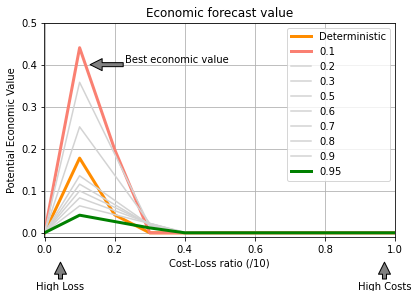

In [12]:
plt.figure()
lw = 3
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.001, 1])
plt.ylim([-0.01, 0.5])
plt.xlabel('Cost-Loss ratio (/10)')
plt.ylabel('Potential Economic Value')
plt.title('Economic forecast value')
plt.plot(C_L[0]*100, V[0], color='darkorange',
         lw=lw, label='Deterministic')
#plt.text(0.005, 0.1, 'Deterministic',fontdict={'size': 9},color='darkorange')
plt.plot(C_L[1]*100, V[1], color="salmon",
         lw=lw, label=str(th_ref[0])) 
for i in range(2, nth):
       plt.plot(C_L[i]*100, V[i],'-', color="lightgray",label=str(th_ref[i-1]))
plt.plot(C_L[nth]*100, V[nth], color='green',
         lw=lw, label=str(th_ref[nth-1]))
plt.annotate('High Loss', xy=(0.14, 0.1),  xycoords='figure fraction',
            xytext=(0.14, 0.0), textcoords='figure fraction',
            arrowprops=dict(facecolor='gray', shrink=1),
            horizontalalignment='center', verticalalignment='bottom',
            )
plt.annotate('High Costs', xy=(0.89, 0.1),  xycoords='figure fraction',
            xytext=(0.89, 0.0), textcoords='figure fraction',
            arrowprops=dict(facecolor='gray', shrink=1),
            horizontalalignment='center', verticalalignment='bottom',
            )
plt.annotate('Best economic value ', xy=(0.13, 0.4),  xycoords='data',
            xytext=(0.23, 0.4), textcoords='data',
            arrowprops=dict(facecolor='gray', shrink=1),
            horizontalalignment='left', verticalalignment='bottom',
            )


plt.legend(loc="upper right")
plt.grid()
#plt.show()


plt.tight_layout()
plt.savefig('/home/nen/Python/images/costloss_prob.png', dpi=100, facecolor='w', edgecolor='w', 
            orientation='portrait', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,metadata=None)
plt.savefig('/home/nen/Python/images/costloss_prob.pdf', dpi=100, facecolor='w', edgecolor='w', 
            orientation='portrait', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,metadata=None)

In [13]:

plt.plot(fpr4, tpr4, color='darkgreen',
         lw=lw, label='3-5 Days (area = %0.2f)' % roc_auc4)
for i in range(0, nth):
   index=np.argmax(thresholds4.round(0) == th_ref[i])
   plt.text(fpr4[index] + 0.01, tpr4[index] + 0.01,str(th_ref[i]), fontdict={'size': 9}, color='darkgreen')
   plt.plot(fpr4[index], tpr4[index] ,'o', color='darkgreen')

plt.plot(fpr6, tpr6, color='darkred',
         lw=lw, label='6-8 Days (area = %0.2f)' % roc_auc6)

for i in range(0, nth):
   index=np.argmax(thresholds6.round(0) == th_ref[i])
   plt.text(fpr6[index] +0.01, tpr6[index] + 0.01,str(th_ref[i]), fontdict={'size': 9}, color='darkred')
   plt.plot(fpr6[index], tpr6[index] ,'o', color='darkred')


NameError: name 'fpr4' is not defined